In [11]:
import os
import re
import tarfile
import urllib.request
from collections import Counter
from html import unescape
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import joblib
import email
import email.policy
import joblib
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from urlextract import URLExtract
import seaborn as sns 
import pandas as pd

In [12]:
# Descargar y preparar datos
RAIZ_DESCARGA = "http://spamassassin.apache.org/old/publiccorpus/"
URL_HAM = RAIZ_DESCARGA + "20030228_easy_ham.tar.bz2"
URL_SPAM = RAIZ_DESCARGA + "20030228_spam.tar.bz2"
RUTA_SPAM = os.path.join("datasets", "spam")


def obtener_datos_spam(url_ham=URL_HAM, url_spam=URL_SPAM, ruta_spam=RUTA_SPAM):
    if not os.path.isdir(ruta_spam):
        os.makedirs(ruta_spam)
    for nombre_archivo, url in (("ham.tar.bz2", url_ham), ("spam.tar.bz2", url_spam)):
        ruta = os.path.join(ruta_spam, nombre_archivo)
        if not os.path.isfile(ruta):
            urllib.request.urlretrieve(url, ruta)
        archivo_tar_bz2 = tarfile.open(ruta)
        archivo_tar_bz2.extractall(path=ruta_spam)
        archivo_tar_bz2.close()


obtener_datos_spam()

In [13]:
# Cargar correos electrónicos
DIR_HAM = os.path.join(RUTA_SPAM, "easy_ham")
DIR_SPAM = os.path.join(RUTA_SPAM, "spam")
nombres_ham = [nombre for nombre in sorted(os.listdir(DIR_HAM)) if len(nombre) > 5]
nombres_spam = [nombre for nombre in sorted(os.listdir(DIR_SPAM)) if len(nombre) > 5]


def cargar_email(es_spam, nombre_archivo, ruta_spam=RUTA_SPAM):
    directorio = "spam" if es_spam else "easy_ham"
    with open(os.path.join(ruta_spam, directorio, nombre_archivo), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)


correos_ham = [cargar_email(False, nombre) for nombre in nombres_ham]
correos_spam = [cargar_email(True, nombre) for nombre in nombres_spam]

# Funciones de procesamiento de texto
stemmer = PorterStemmer()
extractor_urls = URLExtract()

In [14]:
def html_a_texto_plano(html):
    patrones = [
        (r"<head.*?>.*?</head>", ""),
        (r"<a\s.*?>", " HIPERVINCULO "),
        (r"<.*?>", ""),
        (r"(\s*\n)+", "\n"),
    ]
    regex = re.compile("|".join(f"({patron})" for patron, _ in patrones), flags=re.M | re.S | re.I)
    reemplazos = [replacement for _, replacement in patrones]

    def reemplazar(m):
        for i, replacement in enumerate(reemplazos):
            if m.group(i + 1):
                return replacement
        return m.group(0)

    return unescape(regex.sub(reemplazar, html))


def email_a_texto(email):
    html = None
    for parte in email.walk():
        ctype = parte.get_content_type()
        if ctype not in ("text/plain", "text/html"):
            continue
        try:
            contenido = parte.get_payload(decode=True)
            contenido = contenido.decode(parte.get_content_charset() or "utf-8", errors="replace")
        except Exception:
            contenido = parte.get_payload()
        if ctype == "text/plain":
            return contenido.strip()
        else:
            html = contenido
    if html:
        return html_a_texto_plano(html)

In [15]:
# Transformadores personalizados
class TransformadorEmailACounterDePalabras(BaseEstimator, TransformerMixin):
    def __init__(self, convertir_minusculas=True, eliminar_puntuacion=True, reemplazar_urls=True, reemplazar_numeros=True, stemming=True):
        self.convertir_minusculas = convertir_minusculas
        self.eliminar_puntuacion = eliminar_puntuacion
        self.reemplazar_urls = reemplazar_urls
        self.reemplazar_numeros = reemplazar_numeros
        self.stemming = stemming

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        def procesar_email(email):
            texto = email_a_texto(email) or ""
            if self.convertir_minusculas:
                texto = texto.lower()
            if self.reemplazar_urls:
                texto = self._reemplazar_urls(texto)
            if self.reemplazar_numeros:
                texto = re.sub(r"\d+", "NUMERO", texto)
            if self.eliminar_puntuacion:
                texto = re.sub(r"\W+", " ", texto)
            return self._contar_palabras(texto)

        return np.array([procesar_email(email) for email in X])

    def _reemplazar_urls(self, texto):
        urls = extractor_urls.find_urls(texto)
        urls = sorted(set(urls), key=len, reverse=True)
        for url in urls:
            texto = texto.replace(url, " URL ")
        return texto

    def _contar_palabras(self, texto):
        palabras = texto.split()
        conteos = Counter(palabras)
        if self.stemming:
            conteos_stemmed = Counter()
            for palabra, conteo in conteos.items():
                palabra_stemmed = stemmer.stem(palabra)
                conteos_stemmed[palabra_stemmed] += conteo
            return conteos_stemmed
        return conteos


class TransformadorPalabrasClave(BaseEstimator, TransformerMixin):
    def __init__(self, palabras_clave=None):
        self.palabras_clave = palabras_clave or ["oferta", "gratis", "dinero", "fácil", "visita", "compra"]

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([
            {palabra: texto.lower().count(palabra) for palabra in self.palabras_clave}
            for texto in X
        ])


class TransformadorCounterDePalabrasAVector(BaseEstimator, TransformerMixin):
    def __init__(self, tamanio_vocabulario=1000):
        self.tamanio_vocabulario = tamanio_vocabulario

    def fit(self, X, y=None):
        conteo_total = Counter()
        for conteo_palabras in X:
            for palabra, conteo in conteo_palabras.items():
                conteo_total[palabra] += min(conteo, 10)
        mas_comunes = conteo_total.most_common(self.tamanio_vocabulario)
        self.vocabulario_ = {palabra: i + 1 for i, (palabra, _) in enumerate(mas_comunes)}
        return self

    def transform(self, X, y=None):
        filas, columnas, datos = [], [], []
        for i, conteo_palabras in enumerate(X):
            for palabra, conteo in conteo_palabras.items():
                filas.append(i)
                columnas.append(self.vocabulario_.get(palabra, 0))
                datos.append(conteo)
        return csr_matrix((datos, (filas, columnas)), shape=(len(X), self.tamanio_vocabulario + 1))



In [16]:
# Crear pipeline
pipeline_preprocesamiento = Pipeline(
    [
        ("email_a_counter", TransformadorEmailACounterDePalabras()),
        ("counter_a_vector", TransformadorCounterDePalabrasAVector()),
    ]
)

In [17]:
# Crear conjuntos
X = np.array(correos_ham + correos_spam, dtype=object)
y = np.array([0] * len(correos_ham) + [1] * len(correos_spam))

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Transformar datos
X_entrenamiento_transformado = pipeline_preprocesamiento.fit_transform(X_entrenamiento)
X_prueba_transformado = pipeline_preprocesamiento.transform(X_prueba)


              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       505
        Spam       0.97      0.95      0.96        95

    accuracy                           0.99       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.99      0.99      0.99       600



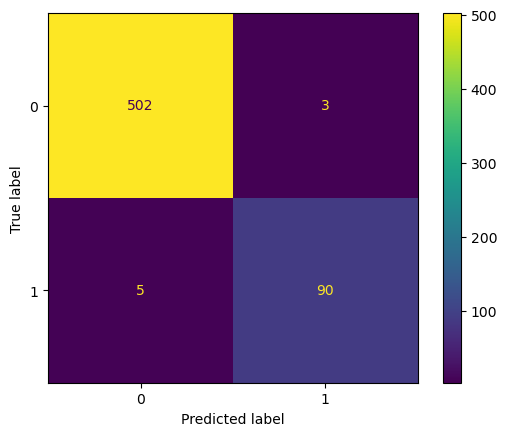

In [18]:
# Entrenar modelo mejorado
modelo_nb = MultinomialNB()
modelo_nb.fit(X_entrenamiento_transformado, y_entrenamiento)

# Evaluar modelo
y_pred = modelo_nb.predict(X_prueba_transformado)

print(classification_report(y_prueba, y_pred, target_names=["Ham", "Spam"]))
ConfusionMatrixDisplay.from_estimator(modelo_nb, X_prueba_transformado, y_prueba)
plt.show()

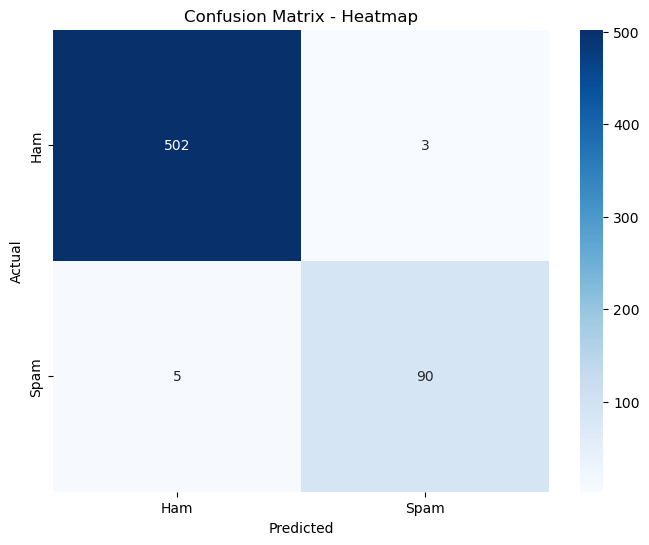

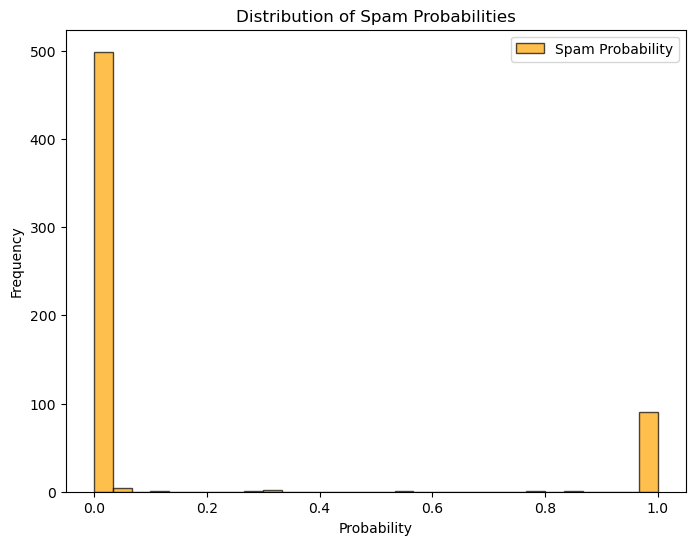

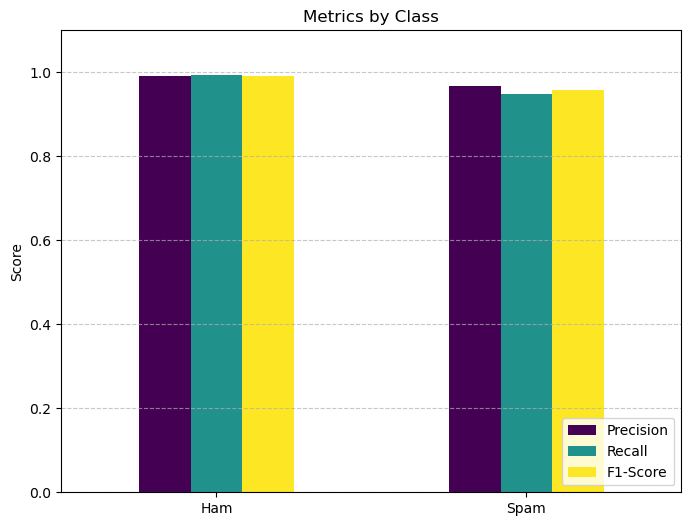

F1 = 0.957
Precision = 0.968
Recall = 0.947


In [19]:
# Visualizaciones avanzadas
# Matriz de confusión con heatmap
conf_matrix = confusion_matrix(y_prueba, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Heatmap")
plt.show()

# Distribución de probabilidades de clasificación
probs = modelo_nb.predict_proba(X_prueba_transformado)
plt.figure(figsize=(8, 6))
plt.hist(probs[:, 1], bins=30, alpha=0.7, label="Spam Probability", color="orange", edgecolor="black")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Spam Probabilities")
plt.legend()
plt.show()

# Gráfico de barras de métricas por clase
metricas = {
    "Precision": precision_score(y_prueba, y_pred, average=None),
    "Recall": recall_score(y_prueba, y_pred, average=None),
    "F1-Score": f1_score(y_prueba, y_pred, average=None),
}

metricas_df = pd.DataFrame(metricas, index=["Ham", "Spam"])
metricas_df.plot(kind="bar", figsize=(8, 6), colormap="viridis")
plt.title("Metrics by Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Métricas globales
print(f"F1 = {f1_score(y_prueba, y_pred):.3f}")
print(f"Precision = {precision_score(y_prueba, y_pred):.3f}")
print(f"Recall = {recall_score(y_prueba, y_pred):.3f}")

# Guardar modelo y pipeline
joblib.dump(modelo_nb, "Spam_Classifier.pkl")
joblib.dump(pipeline_preprocesamiento, "preprocess_pipeline.pkl")

# Cargar modelos y validar
modelo_cargado = joblib.load("Spam_Classifier.pkl")
pipeline_cargado = joblib.load("preprocess_pipeline.pkl")
y_pred_cargado = modelo_cargado.predict(pipeline_cargado.transform(X_prueba))